# LAB 7: Error analysis

Objectives
* Construct an SVM text classifier using `SVC`: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* Compare the result to a linear text classifier
* Evaluate its performance and categorize the errors that it makes
* Examine the model's coefficients and decision function values
* Interpret model results using LIME

In [26]:
# linear-1d svm-hyper plane
import pickle

import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [27]:
train, test = pickle.load(open("/data/politics.pkl", "rb"))

In [28]:
train["pol"].value_counts()

False    7999
True     3413
Name: pol, dtype: int64

In [29]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

In [30]:
train["tokens"] = train["text"].progress_apply(tokenize)
test["tokens"] = test["text"].progress_apply(tokenize)

  0%|          | 0/11412 [00:00<?, ?it/s]

  0%|          | 0/2854 [00:00<?, ?it/s]

------

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [32]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["pol"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2b744ebac110>)),
                ('sgdclassifier', SGDClassifier())])

In [33]:
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["pol"], sgd_predicted))

              precision    recall  f1-score   support

       False       0.94      0.95      0.94      2001
        True       0.88      0.85      0.87       853

    accuracy                           0.92      2854
   macro avg       0.91      0.90      0.91      2854
weighted avg       0.92      0.92      0.92      2854



In [34]:
from sklearn.svm import SVC

In [35]:
svm = make_pipeline(CountVectorizer(analyzer=identity), SVC(kernel="rbf", C=10000))
svm.fit(train["tokens"], train["pol"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2b744ebac110>)),
                ('svc', SVC(C=10000))])

In [36]:
svm_predicted = svm.predict(test["tokens"])
print(classification_report(test["pol"], svm_predicted))

              precision    recall  f1-score   support

       False       0.94      0.95      0.95      2001
        True       0.88      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.91      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854



----

## Hyperparameter search

Find an optimal set of hyperparameters for our models

In [37]:
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [38]:
search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["pol"])

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x2b744ebac110>)),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b745714e9b0>},
                   scoring='f1_macro')

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

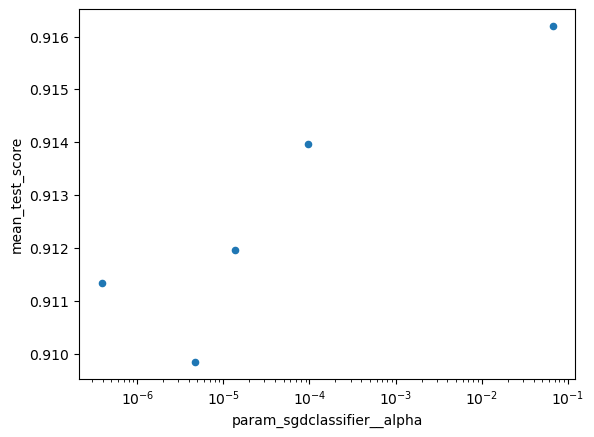

In [39]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

**Seems like 1e-1 seems a good sgd classifier alpha value**

In [40]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.341940,0.030474,0.206452,0.011958,0.066541,{'sgdclassifier__alpha': 0.06654124622275642},0.914785,0.915156,0.924840,0.911181,0.915016,0.916196,0.004568,1
1,1.203369,0.043223,0.193287,0.004077,0.000005,{'sgdclassifier__alpha': 4.725006019194979e-06},0.910760,0.908576,0.914001,0.905654,0.910189,0.909836,0.002735,5
2,1.305560,0.078998,0.206465,0.011609,0.000097,{'sgdclassifier__alpha': 9.661843936169549e-05},0.912476,0.917303,0.916002,0.907885,0.916142,0.913962,0.003442,2
3,1.253486,0.041931,0.197462,0.014862,0.0,{'sgdclassifier__alpha': 3.8630076062271593e-07},0.909683,0.909710,0.917375,0.911710,0.908235,0.911343,0.003212,4
4,1.148354,0.059799,0.183552,0.013998,0.000014,{'sgdclassifier__alpha': 1.3754749578238678e-05},0.910805,0.910273,0.915287,0.913699,0.909770,0.911967,0.002148,3


In [41]:
search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__ngram_range": [(1, 2)],
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["pol"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x2b744ebac110>)),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'countvectorizer__ngram_range': [(1,
                                                                          2)],
                                        'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b7460f84910>},
                   scoring='f1_macro')

In [42]:
search.best_params_, search.best_score_

({'countvectorizer__ngram_range': (1, 2),
  'sgdclassifier__alpha': 0.06144146399234768},
 0.9165821407542876)

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

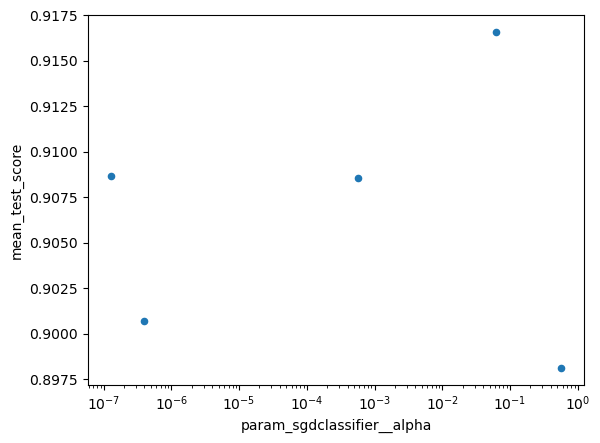

In [43]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

**Seems like 1e-1 is good sgd classifier alpha value for a single gram and bi gram feature extraction**

In [44]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__ngram_range,param_sgdclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.180375,0.053749,0.201217,0.005796,"(1, 2)",0.061441,"{'countvectorizer__ngram_range': (1, 2), 'sgdc...",0.914860,0.914099,0.922880,0.912769,0.918302,0.916582,0.003641,1
1,1.206899,0.023340,0.200407,0.011623,"(1, 2)",0.0,"{'countvectorizer__ngram_range': (1, 2), 'sgdc...",0.893858,0.908174,0.907016,0.905881,0.888682,0.900722,0.007923,4
2,1.217090,0.023922,0.198542,0.004688,"(1, 2)",0.000575,"{'countvectorizer__ngram_range': (1, 2), 'sgdc...",0.905008,0.914813,0.912629,0.895713,0.914758,0.908584,0.007372,3
3,1.229522,0.039848,0.203365,0.007876,"(1, 2)",0.0,"{'countvectorizer__ngram_range': (1, 2), 'sgdc...",0.913155,0.908893,0.913451,0.899611,0.908367,0.908696,0.005004,2
4,1.081110,0.073453,0.188301,0.017874,"(1, 2)",0.576833,"{'countvectorizer__ngram_range': (1, 2), 'sgdc...",0.897881,0.895621,0.901718,0.899859,0.895503,0.898117,0.002413,5


In [45]:
search.best_params_, search.best_score_

({'countvectorizer__ngram_range': (1, 2),
  'sgdclassifier__alpha': 0.06144146399234768},
 0.9165821407542876)

optimized model

In [59]:
sgd.set_params(countvectorizer__ngram_range=(1, 2), sgdclassifier__alpha=(1e-1))
sgd.fit(train["tokens"], train["pol"])
sgd_param_predicted = sgd.predict(test["tokens"])
print(classification_report(test["pol"], sgd_param_predicted))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2001
        True       0.90      0.86      0.88       853

    accuracy                           0.93      2854
   macro avg       0.92      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854



---

## Compare optimized model to baseline

In [60]:
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["pol"], sgd_predicted))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2001
        True       0.90      0.86      0.88       853

    accuracy                           0.93      2854
   macro avg       0.92      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854



In [61]:
svm_predicted = svm.predict(test["tokens"])
print(classification_report(test["pol"], svm_predicted))

              precision    recall  f1-score   support

       False       0.94      0.95      0.95      2001
        True       0.88      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.91      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854



In [62]:
sgd_f1 = f1_score(test["pol"], sgd_predicted)
svm_f1 = f1_score(test["pol"], svm_predicted)
sgd_param_predicted_f1=f1_score(test["pol"], sgd_param_predicted)

In [64]:
sgd_f1, svm_f1,sgd_param_predicted_f1, sgd_f1 - svm_f1

(0.8791340950090198,
 0.8760330578512396,
 0.8791340950090198,
 0.0031010371577802065)

**seems like sgd and sgd with parameter doesnt have much difference**

In [65]:
from scipy.stats import binomtest, wilcoxon

In [66]:
diff = (sgd_predicted == test["pol"]).astype(int) - (
    svm_predicted == test["pol"]
).astype(int)
sum(diff == 1), sum(diff == -1), sum(diff == 0)

(66, 57, 2731)

In [67]:
binomtest(sum(diff == 1), len(diff), alternative="greater")

BinomTestResult(k=66, n=2854, alternative='greater', statistic=0.023125437981779958, pvalue=1.0)

In [68]:
wilcoxon(diff, alternative="greater")

WilcoxonResult(statistic=4092.0, pvalue=0.2085385297602823)

-----

## Save models

Rebuild model with the tokenizer included and save

In [69]:
sgd_all = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=tokenize),
    TfidfTransformer(),
    SGDClassifier(),
)
sgd_all.fit(train["text"], train["pol"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(preprocessor=<cyfunction identity at 0x2b744ebac110>,
                                 tokenizer=<function tokenize at 0x2b74577ccd30>)),
                ('tfidftransformer', TfidfTransformer()),
                ('sgdclassifier', SGDClassifier())])

In [70]:
svm_all = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=tokenize),
    TfidfTransformer(),
    SVC(kernel="rbf", C=10000),
)
svm_all.fit(train["text"], train["pol"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(preprocessor=<cyfunction identity at 0x2b744ebac110>,
                                 tokenizer=<function tokenize at 0x2b74577ccd30>)),
                ('tfidftransformer', TfidfTransformer()),
                ('svc', SVC(C=10000))])

In [71]:
import cloudpickle

In [72]:
cloudpickle.dump(sgd_all, open("sgd.model", "wb"))
cloudpickle.dump(svm_all, open("svm.model", "wb"))

**Conclusion:**

**After the hyperparameter search with the sgd,it seems like both are giving same f1 score. So any of both can be used or we can search for better parameters for a better f1 score**